In [1]:
import findspark
findspark.init() #Por defecto findspark mira en la variable de entorno del sistema SPARK_HOME

In [2]:
%matplotlib inline
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, DoubleType
from pyspark.sql import functions as F
from pyspark.sql import Window as W
import pandas as pd
import seaborn as sns
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

In [3]:
spark = (SparkSession.builder
        .master('spark://driver-ip:7077')
        .appName('kaggle_challenge')
        .config(key = 'spark.driver.cores', value = '4')
        .config(key = 'spark.driver.memory', value = '15G')
        .config(key = 'spark.executor.memory', value = '3456M') 
        .config(key = 'spark.executor.cores', value = '1')
        .config(key = 'spark.shuffle.service.enabled', value = 'true')
        .config(key = 'spark.dynamicAllocation.enabled', value = 'true')
        .config(key = 'spark.dynamicAllocation.minExecutors', value = '2')
        .config(key = 'spark.dynamicAllocation.maxExecutors', value = '6')
        .config(key = 'spark.network.timeout', value = '300s')
        .config(key = 'spark.driver.maxResultSize', value = '14G')
        .getOrCreate()
       )
#obtenemos el sparkcontext a partir del sparksession
sc = spark.sparkContext

En el worker con Windows el archivo está en la raíz del disco C (C:/) y en el driver y el otro worker (ambos Linux) están en la carpeta /C: (una carpeta llamada C: dentro del directorio raíz)

In [4]:
# ip,app,device,os,channel,click_time,attributed_time,is_attributed

train_df = spark.read.csv('file:/C:/train.csv', 
               header = True, 
               mode = 'DROPMALFORMED', 
               schema = StructType([StructField('ip', IntegerType()), 
                                    StructField('app', IntegerType()), 
                                    StructField('device', IntegerType()),
                                    StructField('os', IntegerType()),
                                    StructField('channel', IntegerType()),
                                    StructField('click_time', TimestampType(), True),
                                    StructField('attributed_time', TimestampType(), True),
                                    StructField('is_attributed', IntegerType())
                                   ]),
               timestampFormat='yyyy-MM-dd HH:mm:ss'
              )

Notas:
- ✓ Sacar variable que indique día de la semana 
- ✓ Observar cuántos dispositivos distintos hay asociados en una misma ip
- ✓ Observar número de canales por app
- ✓ Observar diferencia entre tiempo que pasa desde que se hace el primer click hasta que se convierte en attributed
- ✓ Observar cuántas veces se hace click hasta que se convierte en attributed
- ✓ Observar cuántas canales distintos tienen los usuarios (ip, device, os) que han convertido y cuántos los que no
- ✓ Explorar las variables relativas a dispositivos (devices y os)
- ✓ Sacar variable que indique la diferencia en minutos desde el primer click de un usuario concreto (ip, device, os) hasta ese click en concreto. Si el usuario convierte, entonces se resetea el contador de diferencia y el primero será el siguiente registro al convertido (ordenados por tiempo).
- ✓ Sacar variable que indique número de clicks desde el primer click de un usuario concreto hasta ese click en ese momento. De la misma manera que el punto anterior, si convierte se resetea el contador y el primero pasa a ser el siguiente al convertido.
- ✓ Sacar dos variables que cataloguen tanto a device como a os en distintas categorías en función de porcentaje de conversión que tienen (teniendo en cuenta el número de observaciones que constituyen, ver abajo).
- ✓ Explorar horas y meses
- ✓ Sacar variable de horas
- ✓ Hacer con app y channel lo mismo que se ha hecho con device y os (score y cortarlas)

#### Feature engineering

In [8]:
# train_df.count()

184903890

Sacar variable que indique día de la semana

In [21]:
train_df = train_df.select('ip', 'app', 'device' ,'os', 'channel', 'click_time', 
                F.date_format('click_time', 'E').alias('click_time_wday'), 
                'attributed_time', F.date_format('attributed_time', 'E').alias('attributed_time_wday'), 
                'is_attributed')

train_df.persist(pyspark.StorageLevel.MEMORY_AND_DISK_SER)

train_df.show(n = 10, truncate = False)

+------+---+------+---+-------+-------------------+---------------+---------------+--------------------+-------------+
|ip    |app|device|os |channel|click_time         |click_time_wday|attributed_time|attributed_time_wday|is_attributed|
+------+---+------+---+-------+-------------------+---------------+---------------+--------------------+-------------+
|83230 |3  |1     |13 |379    |2017-11-06 14:32:21|Mon            |null           |null                |0            |
|17357 |3  |1     |19 |379    |2017-11-06 14:33:34|Mon            |null           |null                |0            |
|35810 |3  |1     |13 |379    |2017-11-06 14:34:12|Mon            |null           |null                |0            |
|45745 |14 |1     |13 |478    |2017-11-06 14:34:52|Mon            |null           |null                |0            |
|161007|3  |1     |13 |379    |2017-11-06 14:35:08|Mon            |null           |null                |0            |
|18787 |3  |1     |16 |379    |2017-11-06 14:36:

Sacar variable que indique la hora

In [45]:
train_df = train_df.withColumn('click_time_hour', F.date_format('click_time', 'H'))            

train_df.persist(pyspark.StorageLevel.MEMORY_AND_DISK_SER)

train_df.show(n = 10, truncate = False)

+------+---+------+---+-------+-------------------+---------------+---------------+--------------------+-------------+-----------------+-------------------+------+----------+---------------+
|device|os |ip    |app|channel|click_time         |click_time_wday|attributed_time|attributed_time_wday|is_attributed|n_previous_clicks|click_time_diff    |os_cat|device_cat|click_time_hour|
+------+---+------+---+-------+-------------------+---------------+---------------+--------------------+-------------+-----------------+-------------------+------+----------+---------------+
|148   |29 |100141|19 |213    |2017-11-09 08:36:34|Thu            |null           |null                |0            |0                |0.0                |F     |J         |8              |
|148   |29 |91006 |19 |282    |2017-11-08 17:27:29|Wed            |null           |null                |0            |0                |0.0                |F     |J         |17             |
|148   |29 |58891 |83 |320    |2017-11-09 00:

### Observar cuántos registros tiene cada ip

In [20]:
ip_counts = train_df.select('ip').groupBy('ip').count()

ip_counts.persist(pyspark.StorageLevel.MEMORY_AND_DISK_SER)

DataFrame[ip: int, count: bigint]

In [21]:
ip_counts.describe('count').show(truncate = False)

+-------+-----------------+
|summary|count            |
+-------+-----------------+
|count  |277396           |
|mean   |666.570137997664 |
|stddev |5446.831261798024|
|min    |1                |
|max    |1238734          |
+-------+-----------------+



In [22]:
# Mediana
ip_counts.approxQuantile(col = 'count', probabilities = [0.5], relativeError = 0.25)

[30237.0]

In [23]:
ip_counts.unpersist()

DataFrame[ip: int, count: bigint]

### Dispositivos asociados por IP

In [38]:
ip_devices_count = train_df.select('ip', 'device', 'os').distinct().groupBy('ip').count()

ip_devices_count.persist(pyspark.StorageLevel.MEMORY_AND_DISK_SER)

DataFrame[ip: int, count: bigint]

In [39]:
ip_devices_count.describe('count').show(truncate = False)

+-------+------------------+
|summary|count             |
+-------+------------------+
|count  |277396            |
|mean   |12.069885650838513|
|stddev |20.40543341143467 |
|min    |1                 |
|max    |772               |
+-------+------------------+



In [40]:
# Mediana
ip_devices_count.approxQuantile(col = 'count', probabilities = [0.25, 0.5, 0.75], relativeError = 0.25)

[1.0, 198.0, 772.0]

Es raro que una misma IP tenga tantos dispositivos asociados. Además, tampoco podemos saber si una persona ha actualizado su movil a lo largo del tiempo (según nuestra consulta SQL, cuenta como varios dispositivos) o si realmente hay varios dispositivos con distinta versión de s.o.. De la misma manera, si varias personas conectadas a una misma IP tienen el mismo móvil y la misma versión de sistema operativo, según nuestra consulta cuenta como el mismo móvil.

También, una IP puede cambiar a lo largo del tiempo, lo que dificulta aún más la interpretación de la consulta.

Esta consulta nos puede dar una idea de cuántos dispositivos hay bajo una misma IP pero la reflexión anterior me hace pensar que es mejor no tener en cuenta esta consulta a efectos prácticos.

In [41]:
ip_devices_count.unpersist()

DataFrame[ip: int, count: bigint]

### Número de canales por app

In [34]:
channels_per_app_count = (train_df.select('app', 'channel')
                                  .distinct()
                                  .groupBy('app')
                                  .count())

channels_per_app_count.persist(pyspark.StorageLevel.MEMORY_AND_DISK_SER)

DataFrame[app: int, count: bigint]

In [35]:
channels_per_app_count.describe('count').show(truncate = False)

+-------+-----------------+
|summary|count            |
+-------+-----------------+
|count  |706              |
|mean   |2.011331444759207|
|stddev |4.052476582497506|
|min    |1                |
|max    |49               |
+-------+-----------------+



In [36]:
# Mediana
channels_per_app_count.approxQuantile(col = 'count', probabilities = [0.25, 0.5, 0.75], relativeError = 0.25)

[1.0, 4.0, 49.0]

In [ ]:
channels_per_app_count_pd = channels_per_app_count.toPandas()

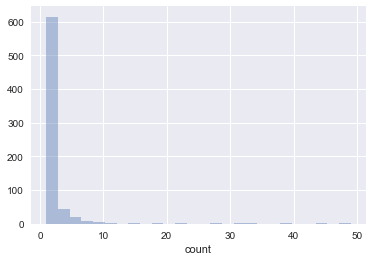

In [49]:
sns.distplot(channels_per_app_count_pd['count'], kde=False, rug=False)

sns.plt.show()

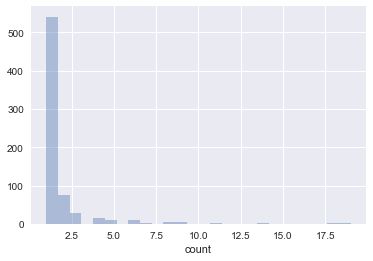

In [50]:
sns.distplot(channels_per_app_count_pd['count'][channels_per_app_count_pd['count'] < 20], kde=False, rug=False)

sns.plt.show()

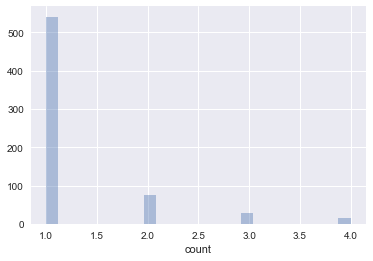

In [51]:
sns.distplot(channels_per_app_count_pd['count'][channels_per_app_count_pd['count'] < 5], kde=False, rug=False)

sns.plt.show()

La gran mayoría de apps tienen sólo un canal, aunque como se ve hay excepciones en las que hay más de un canal (49 canales como máximo)

In [37]:
channels_per_app_count.unpersist()

DataFrame[app: int, count: bigint]

### Observar cuántos canales distintos tienen los usuarios (ip, device, os) que han convertido y cuántos los que no

1. Coger los registros con is_attributed == 1 y hacerle distinct
2. Coger los regustros con is_attributed == 0 y hacerle distinct
3. Join del punto 1 con el punto 2
4. Hacer un distinct por usuario y channel
5. groupBy usuario
6. Hacer un count (se estará contando implicitamente el número de canales distintos por usuario)

In [7]:
only_attributed = train_df.select('ip', 'device', 'os', 'channel', 'is_attributed').filter(train_df.is_attributed == 1).drop('is_attributed').distinct()
only_not_attributed = train_df.select('ip', 'device', 'os', 'channel', 'is_attributed').filter(train_df.is_attributed == 0).drop('is_attributed').distinct()

In [10]:
joined = (only_attributed.join(only_not_attributed, 
                                ['ip', 'device', 'os'],
                               'inner')
                           .distinct())

joined = joined.groupBy('ip', 'device', 'os').count()

joined.persist(pyspark.StorageLevel.MEMORY_AND_DISK_SER)

joined.describe('count').show(truncate = False)

+-------+-----------------+
|summary|count            |
+-------+-----------------+
|count  |224909           |
|mean   |46.10132542494965|
|stddev |126.1820537984589|
|min    |1                |
|max    |9108             |
+-------+-----------------+



In [11]:
channels_per_attributed_user_pd = joined.toPandas()

In [17]:
# Mediana
channels_per_attributed_user_pd['count'].median()

5.0

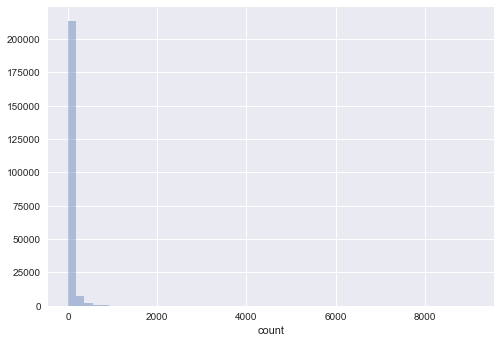

In [12]:
sns.distplot(channels_per_attributed_user_pd['count'], kde=False, rug=False)

sns.plt.show()

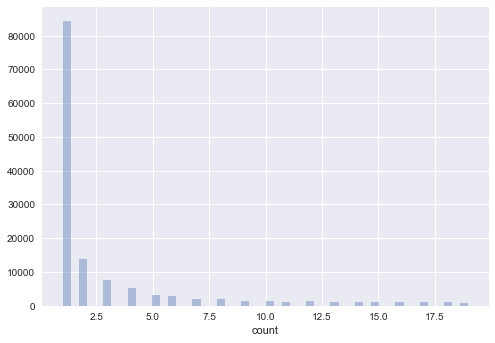

In [24]:
sns.distplot(channels_per_attributed_user_pd['count'][channels_per_attributed_user_pd['count'] < 20], kde=False, rug=False)

sns.plt.show()

In [18]:
joined.unpersist()

DataFrame[ip: int, device: int, os: int, count: bigint]

Para los que no han convertido nunca el procedimiento sería similar pero asegurándose de que nunca ha convertido: para esto quizás sería interesante hacer una columna auxiliar que sume "is_attributed" para cada usuario: si es > 1, ha atribuido alguna vez y descartamos esos registros, si es == 0 estaremos seguros que nunca ha atribuido.

In [39]:
w = W.partitionBy('ip', 'device', 'os').orderBy('is_attributed')
never_attributed = (train_df.select('ip', 'device', 'os', 'channel', 'is_attributed')
                            .withColumn('ever_attributed', F.sum('is_attributed').over(w)))
never_attributed = (never_attributed.filter(never_attributed.ever_attributed == 0)                            
                                    .drop('ever_attributed')
                                    .drop('is_attributed')
                                    .distinct()
                                    .groupBy('ip', 'device', 'os')
                                    .count())

never_attributed.persist(pyspark.StorageLevel.MEMORY_AND_DISK_SER)

never_attributed.describe('count').show(truncate = False)

+-------+------------------+
|summary|count             |
+-------+------------------+
|count  |3204352           |
|mean   |12.934064672046018|
|stddev |18.533817876211582|
|min    |1                 |
|max    |142               |
+-------+------------------+



In [40]:
channels_per_not_attributed_user_pd = never_attributed.toPandas()

In [41]:
# Mediana
channels_per_not_attributed_user_pd['count'].median()

4.0

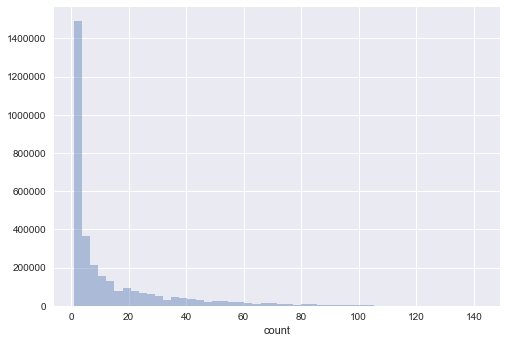

In [42]:
sns.distplot(channels_per_not_attributed_user_pd['count'], kde=False, rug=False)

sns.plt.show()

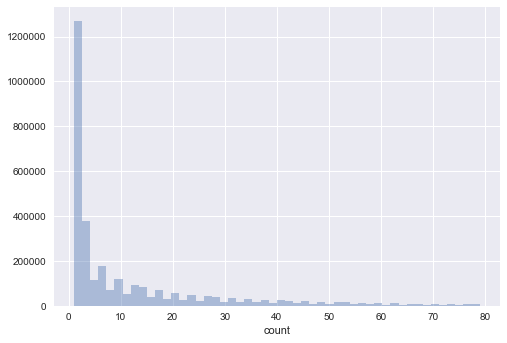

In [43]:
sns.distplot(channels_per_not_attributed_user_pd['count'][channels_per_not_attributed_user_pd['count'] < 80], kde=False, rug=False)

sns.plt.show()

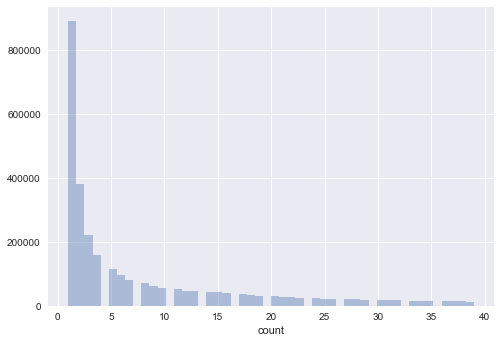

In [44]:
sns.distplot(channels_per_not_attributed_user_pd['count'][channels_per_not_attributed_user_pd['count'] < 40], kde=False, rug=False)

sns.plt.show()

In [ ]:
never_attributed.unpersist()

In [45]:
channels_per_attributed_user_pd_cat = channels_per_attributed_user_pd.assign(is_attributed='yes')
channels_per_not_attributed_user_pd_cat = channels_per_not_attributed_user_pd.assign(is_attributed='no')

In [46]:
all_counted = pd.concat([channels_per_attributed_user_pd_cat, channels_per_not_attributed_user_pd_cat])

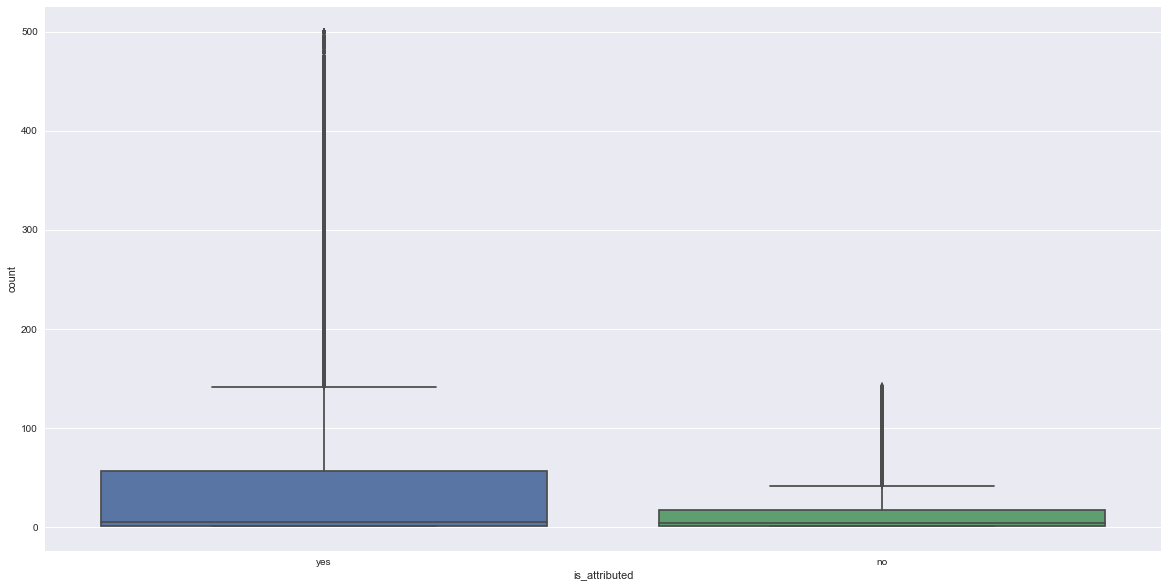

In [51]:
sns.plt.figure(figsize=(20, 10))
sns.boxplot(x='is_attributed', y='count', data=all_counted[all_counted['count'] <= 500])
sns.plt.show()

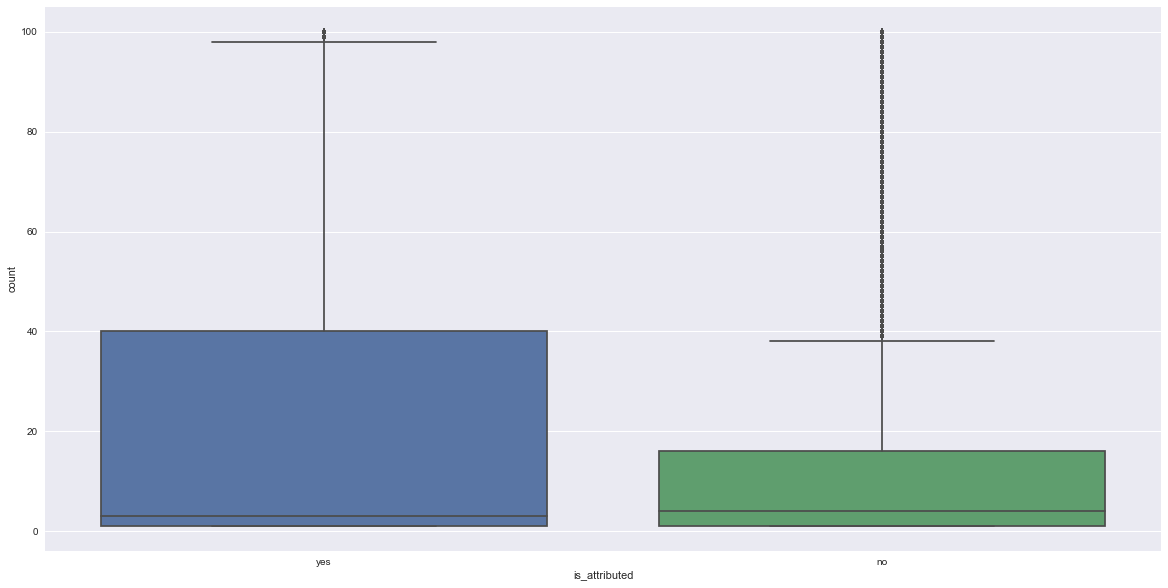

In [52]:
sns.plt.figure(figsize=(20, 10))
sns.boxplot(x='is_attributed', y='count', data=all_counted[all_counted['count'] <= 100])
sns.plt.show()

No parece haber diferencias visibles entre número de canales por los que se ha pasado y si se ha convertido o no.

### Observar diferencia entre tiempo que pasa desde que se hace el primer click hasta que se convierte en attributed

In [34]:
ever_attributed = (train_df.select('ip', 'device', 'os', 'click_time', 'is_attributed')
                           .groupBy('ip', 'device', 'os')
                           .agg({'is_attributed': 'sum'})
                           .withColumnRenamed('sum(is_attributed)', 'ever_attributed')
                           .join(train_df, ['ip', 'device', 'os'], 'inner'))
# Ahora me tengo que quedar con el primer registro del usuario (el más antiguo) y el primero de ese usuario que sea atributed, y luego hacer la diferencia 
#de fechas entre click_time y attributed_time

ever_attributed.persist(pyspark.StorageLevel.MEMORY_AND_DISK_SER)

ever_attributed.show(truncate = False)

+------+------+---+---------------+---+-------+-------------------+---------------+---------------+--------------------+-------------+
|ip    |device|os |ever_attributed|app|channel|click_time         |click_time_wday|attributed_time|attributed_time_wday|is_attributed|
+------+------+---+---------------+---+-------+-------------------+---------------+---------------+--------------------+-------------+
|83230 |1     |13 |8              |3  |379    |2017-11-06 14:32:21|Mon            |null           |null                |0            |
|17357 |1     |19 |9              |3  |379    |2017-11-06 14:33:34|Mon            |null           |null                |0            |
|35810 |1     |13 |2              |3  |379    |2017-11-06 14:34:12|Mon            |null           |null                |0            |
|45745 |1     |13 |36             |14 |478    |2017-11-06 14:34:52|Mon            |null           |null                |0            |
|161007|1     |13 |0              |3  |379    |2017-11-

In [43]:
# Un dataframe cogiendo sólo los primeros
w_click_time = W.partitionBy('ip', 'device', 'os').orderBy('click_time')

only_firsts = ever_attributed.filter('ever_attributed > 0').filter('is_attributed == 0').withColumn('index', F.rank().over(w_click_time)).filter('index == 1').drop('index')

# Otro dataframe cogiendo sólo los que son attributed (y a su vez cogiendo sólo los primeros, es decir un sólo attributed por usuario)
only_attributed = ever_attributed.filter('is_attributed == 1').withColumn('index', F.rank().over(w_click_time)).filter('index == 1').drop('index')

only_firsts.persist(pyspark.StorageLevel.MEMORY_AND_DISK_SER)
only_attributed.persist(pyspark.StorageLevel.MEMORY_AND_DISK_SER)

only_firsts.show(truncate = False)
only_attributed.show(truncate = False)

+----+------+---+---------------+---+-------+-------------------+---------------+---------------+--------------------+-------------+
|ip  |device|os |ever_attributed|app|channel|click_time         |click_time_wday|attributed_time|attributed_time_wday|is_attributed|
+----+------+---+---------------+---+-------+-------------------+---------------+---------------+--------------------+-------------+
|150 |1     |19 |1              |15 |245    |2017-11-06 16:35:22|Mon            |null           |null                |0            |
|705 |1     |17 |1              |9  |244    |2017-11-06 18:24:29|Mon            |null           |null                |0            |
|991 |1     |17 |1              |12 |328    |2017-11-06 17:03:07|Mon            |null           |null                |0            |
|991 |1     |17 |1              |2  |212    |2017-11-06 17:03:07|Mon            |null           |null                |0            |
|1012|1     |13 |1              |3  |442    |2017-11-06 16:01:03|Mon 

In [44]:
attributed_and_not_attributed = only_firsts.union(only_attributed)

attributed_and_not_attributed.persist(pyspark.StorageLevel.MEMORY_AND_DISK_SER)

attributed_and_not_attributed.show(truncate = False)

+----+------+---+---------------+---+-------+-------------------+---------------+---------------+--------------------+-------------+
|ip  |device|os |ever_attributed|app|channel|click_time         |click_time_wday|attributed_time|attributed_time_wday|is_attributed|
+----+------+---+---------------+---+-------+-------------------+---------------+---------------+--------------------+-------------+
|150 |1     |19 |1              |15 |245    |2017-11-06 16:35:22|Mon            |null           |null                |0            |
|705 |1     |17 |1              |9  |244    |2017-11-06 18:24:29|Mon            |null           |null                |0            |
|991 |1     |17 |1              |12 |328    |2017-11-06 17:03:07|Mon            |null           |null                |0            |
|991 |1     |17 |1              |2  |212    |2017-11-06 17:03:07|Mon            |null           |null                |0            |
|1012|1     |13 |1              |3  |442    |2017-11-06 16:01:03|Mon 

In [47]:
click_diffs = (attributed_and_not_attributed.withColumn('prev_value', F.lag('click_time').over(w_click_time))
                                            .orderBy(attributed_and_not_attributed.click_time.desc())                                            
              )

click_diffs = (click_diffs.withColumn('click_time_diff', F.abs( F.when( F.isnull(F.dayofyear(click_diffs.click_time) - F.dayofyear(click_diffs.prev_value)), 0 )
                                                                 .otherwise(F.dayofyear(click_diffs.click_time) - F.dayofyear(click_diffs.prev_value)))
                                                         )
              )

click_diffs.persist(pyspark.StorageLevel.MEMORY_AND_DISK_SER)

click_diffs.describe('click_time_diff').show(truncate = False)

+-------+-------------------+
|summary|click_time_diff    |
+-------+-------------------+
|count  |648721             |
|mean   |0.23031318548343588|
|stddev |0.6033471929407952 |
|min    |0                  |
|max    |3                  |
+-------+-------------------+



In [49]:
click_diffs_pd = click_diffs.select('click_time_diff').toPandas()

In [51]:
click_diffs_pd.median()

click_time_diff    0.0
dtype: float64

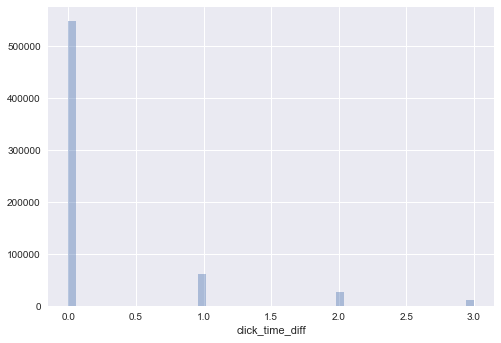

In [52]:
sns.distplot(click_diffs_pd['click_time_diff'], kde=False, rug=False)

sns.plt.show()

Dado que en muchas ocasiones no hay diferencia entre días, exploremos la diferencia entre horas.

In [55]:
click_diffs = (attributed_and_not_attributed.withColumn('prev_value', F.lag('click_time').over(w_click_time))
                                            .orderBy(attributed_and_not_attributed.click_time.desc())                                            
              )

click_diffs = (click_diffs.withColumn('click_time_diff', F.abs( F.when( F.isnull(click_diffs.click_time.cast('long') - click_diffs.prev_value.cast('long') ), 0 )
                                                                 .otherwise( click_diffs.click_time.cast('long') - click_diffs.prev_value.cast('long') )
                                                              ) / 3600
                                     )
              )

click_diffs.persist(pyspark.StorageLevel.MEMORY_AND_DISK_SER)

click_diffs.describe('click_time_diff').show(truncate = False)

+-------+------------------+
|summary|click_time_diff   |
+-------+------------------+
|count  |648721            |
|mean   |4.474332042074582 |
|stddev |12.025348377973328|
|min    |0.0               |
|max    |71.98972222222223 |
+-------+------------------+



In [56]:
click_diffs_pd = click_diffs.select('click_time_diff').toPandas()

In [57]:
click_diffs_pd.median()

click_time_diff    0.0
dtype: float64

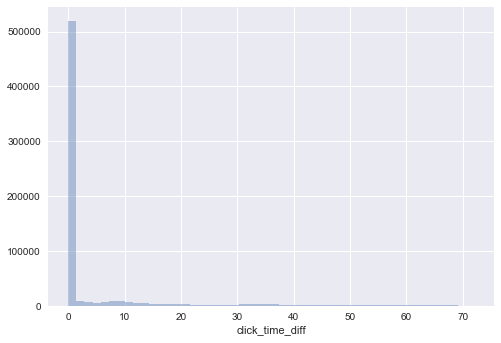

In [58]:
sns.distplot(click_diffs_pd['click_time_diff'], kde=False, rug=False)

sns.plt.show()

Es probable que los 0 aparezcan porque son casos en los que son usuarios únicos y la primera y última vez de los que se tiene registros, convirtieron a la primera.

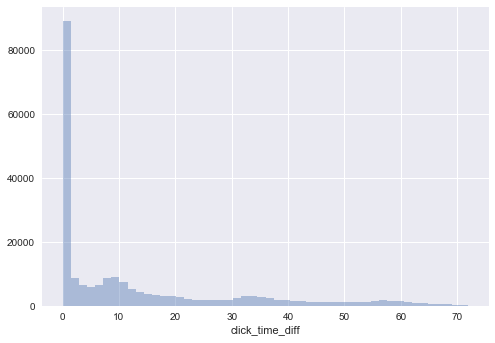

In [63]:
sns.distplot(click_diffs_pd['click_time_diff'][click_diffs_pd['click_time_diff'] > 0], kde=False, rug=False)

sns.plt.show()

Hay muchos casos en los que la diferencia es de menos de una hora, así que luego exploraremos esto de nuevo pero desde los minutos.

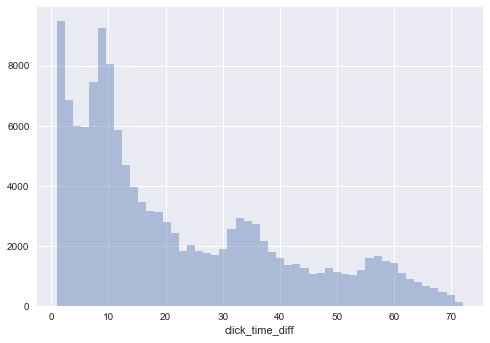

In [64]:
sns.distplot(click_diffs_pd['click_time_diff'][click_diffs_pd['click_time_diff'] >= 1], kde=False, rug=False)

sns.plt.show()

Existen picos a la hora, entorno a las 10 horas, entre las 30 y 40 horas y cerca de las 60 horas.

In [65]:
click_diffs = (attributed_and_not_attributed.withColumn('prev_value', F.lag('click_time').over(w_click_time))
                                            .orderBy(attributed_and_not_attributed.click_time.desc())                                            
              )

click_diffs = (click_diffs.withColumn('click_time_diff', F.abs( F.when( F.isnull(click_diffs.click_time.cast('long') - click_diffs.prev_value.cast('long') ), 0 )
                                                                 .otherwise( click_diffs.click_time.cast('long') - click_diffs.prev_value.cast('long') )
                                                              ) / 60
                                     )
              )

click_diffs.persist(pyspark.StorageLevel.MEMORY_AND_DISK_SER)

click_diffs.describe('click_time_diff').show(truncate = False)

+-------+------------------+
|summary|click_time_diff   |
+-------+------------------+
|count  |648721            |
|mean   |268.45992252447513|
|stddev |721.5209026783995 |
|min    |0.0               |
|max    |4319.383333333333 |
+-------+------------------+



In [66]:
click_diffs_pd = click_diffs.select('click_time_diff').toPandas()

In [67]:
click_diffs_pd.median()

click_time_diff    0.0
dtype: float64

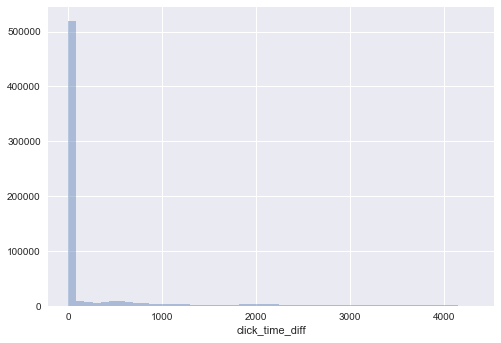

In [68]:
sns.distplot(click_diffs_pd['click_time_diff'], kde=False, rug=False)

sns.plt.show()

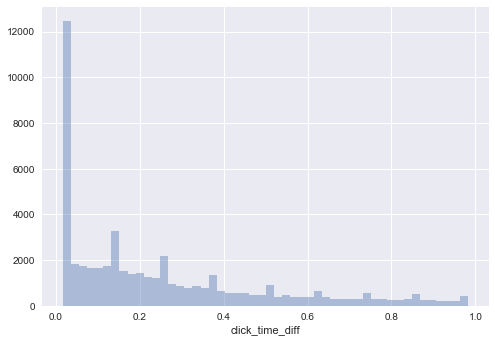

In [74]:
sns.distplot(click_diffs_pd['click_time_diff'][(click_diffs_pd['click_time_diff'] > 0) & (click_diffs_pd['click_time_diff'] < 1)], kde=False, rug=False)

sns.plt.show()

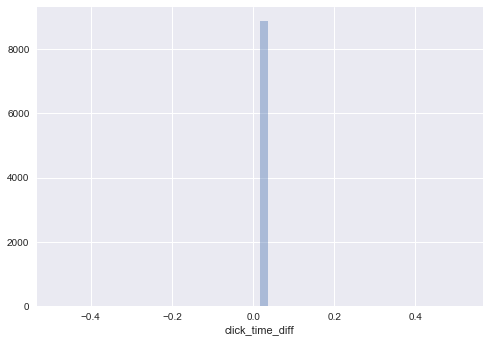

In [76]:
sns.distplot(click_diffs_pd['click_time_diff'][(click_diffs_pd['click_time_diff'] > 0) & (click_diffs_pd['click_time_diff'] < 0.025)], kde=False, rug=False)

sns.plt.show()

In [77]:
click_diffs_pd['click_time_diff'][(click_diffs_pd['click_time_diff'] > 0) & (click_diffs_pd['click_time_diff'] < 0.025)].head(10)

15     0.016667
72     0.016667
81     0.016667
135    0.016667
145    0.016667
151    0.016667
225    0.016667
235    0.016667
246    0.016667
282    0.016667
Name: click_time_diff, dtype: float64

In [79]:
click_diffs_pd['click_time_diff'][(click_diffs_pd['click_time_diff'] > 0) & (click_diffs_pd['click_time_diff'] < 0.01666)].head(10)

Series([], Name: click_time_diff, dtype: float64)

Hay muchos casos en los que la diferencia de tiempo es de 0.016667 minutos.

In [98]:
click_diffs.unpersist()

DataFrame[ip: int, device: int, os: int, ever_attributed: bigint, app: int, channel: int, click_time: timestamp, click_time_wday: string, attributed_time: timestamp, attributed_time_wday: string, is_attributed: int, prev_value: timestamp, click_time_diff: double]

### Observar cuántas veces se hace click hasta que se convierte en attributed

In [88]:
times_clicked = attributed_and_not_attributed.withColumn('index', F.rank().over(w_click_time)).filter('is_attributed == 1')

times_clicked.persist(pyspark.StorageLevel.MEMORY_AND_DISK_SER)

times_clicked.describe('index').show(truncate = False)

+-------+------------------+
|summary|index             |
+-------+------------------+
|count  |368930            |
|mean   |1.6603827284308676|
|stddev |0.7994985505188071|
|min    |1                 |
|max    |17                |
+-------+------------------+



In [89]:
times_clicked_pd = times_clicked.select('index').toPandas()

In [90]:
times_clicked_pd.median()

index    2.0
dtype: float64

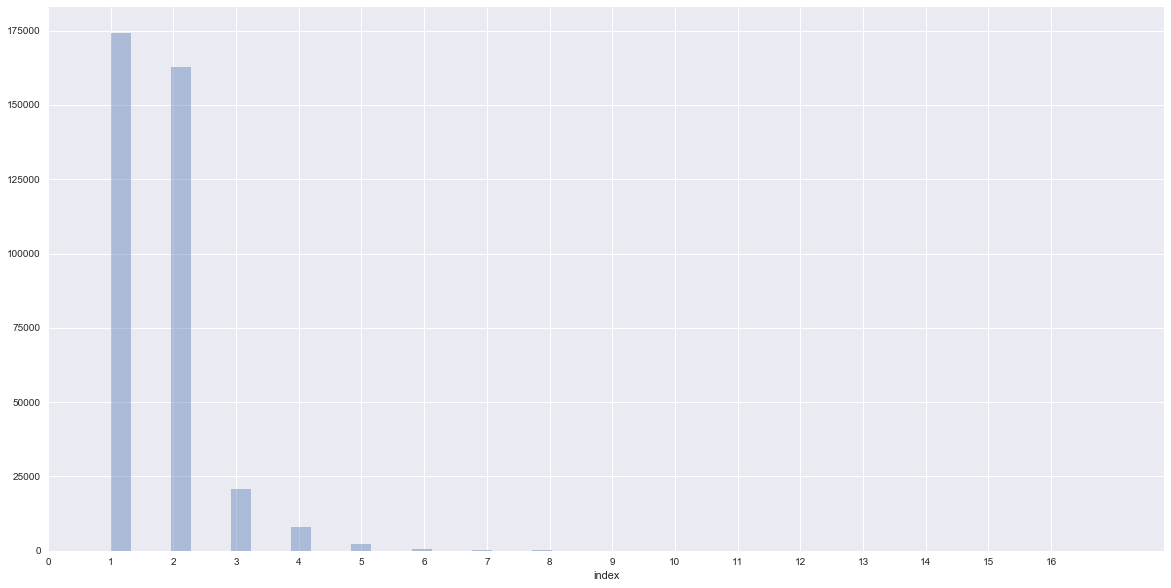

In [97]:
sns.plt.figure(figsize=(20, 10))
sns.distplot(times_clicked_pd['index'], kde=False, rug=False)
sns.plt.xticks(range(0, 17, 1))
sns.plt.show()

In [99]:
attributed_and_not_attributed.unpersist()
only_firsts.unpersist()
only_attributed.unpersist()
ever_attributed.unpersist()

DataFrame[ip: int, device: int, os: int, ever_attributed: bigint, app: int, channel: int, click_time: timestamp, click_time_wday: string, attributed_time: timestamp, attributed_time_wday: string, is_attributed: int]

Parece haber una gran cantidad de clicks que convierten en la primera vez, y un número similar que lo hace la segunda vez. A partir de ahí el número de conversiones baja drásticamente.

### Información sobre los móviles

In [ ]:
count_mobile_groups = train_df.select('device', 'os').groupBy('device', 'os').count()
count_mobile_groups.orderBy(count_mobile_groups['count'].desc())

In [ ]:
count_mobile_groups_no_os = train_df.select('device').groupBy('device').count()
count_mobile_groups_no_os.orderBy(count_mobile_groups_no_os['count'].desc())

In [ ]:
count_mobile_isattributed_groups_no_os = train_df.select('device', 'is_attributed').groupBy('device', 'is_attributed').count()

count_mobile_isattributed_groups_no_os.persist(pyspark.StorageLevel.MEMORY_AND_DISK_SER)

count_mobile_isattributed_groups_no_os.orderBy(count_mobile_isattributed_groups_no_os['count'].desc(), count_mobile_isattributed_groups_no_os['device'])

In [ ]:
count_mobile_isattributed_groups_no_os.orderBy('device')

Partir la variable "device" y "os" en distintas categorías (Ej: A compuesta por 1, 2, 3, la B compuesta por 4, 5, 6, ...) en función del porcentaje de atribución que dan.

In [ ]:
aux = (train_df.select('device', 'is_attributed')
               .groupBy('device')
               .pivot('is_attributed')
               .count())

aux = (aux.withColumn('prcnt_0', F.when(~F.isnull('0') & ~F.isnull('1'), (aux['0'] / (aux['0'] + aux['1'])) * 100).otherwise(None))
          .withColumn('prcnt_1', F.when(~F.isnull('0') & ~F.isnull('1'), (aux['1'] / (aux['0'] + aux['1'])) * 100).otherwise(None))
      )

(aux.filter((aux['0'] + aux['1']) >= 1000) # Que como mínimo lleguen a un cierto número de registros
   .orderBy(aux['prcnt_1'].desc()))

In [ ]:
aux2 = (train_df.select('os', 'is_attributed')
               .groupBy('os')
               .pivot('is_attributed')
               .count())

aux2 = (aux2.withColumn('prcnt_0', F.when(~F.isnull('0') & ~F.isnull('1'), (aux2['0'] / (aux2['0'] + aux2['1'])) * 100).otherwise(None))
          .withColumn('prcnt_1', F.when(~F.isnull('0') & ~F.isnull('1'), (aux2['1'] / (aux2['0'] + aux2['1'])) * 100).otherwise(None))
      )

(aux2.filter((aux2['0'] + aux2['1']) >= 1000) # Que como mínimo lleguen a un cierto número de registros
   .orderBy(aux2['prcnt_1'].desc()))

Explorar meses y horas

In [27]:
wday_count = train_df.select('click_time_wday', 'is_attributed').groupBy('click_time_wday', 'is_attributed').count().toPandas()

In [26]:
wday_count.sort_values(['click_time_wday', 'is_attributed'])

,click_time_wday,is_attributed,count
1,Mon,0,9291174
5,Mon,1,17394
3,Thu,0,52882970
2,Thu,1,133967
6,Tue,0,59481146
0,Tue,1,152164
4,Wed,0,62791754
7,Wed,1,153321


In [30]:
hour_count = train_df.select(F.date_format('click_time', 'H').alias('click_time_hour'), 'is_attributed').groupBy('click_time_hour', 'is_attributed').count().toPandas()

In [42]:
# hour_count['click_time_hour'] = pd.to_numeric(hour_count['click_time_hour'])

hour_count_ordered = hour_count.where(hour_count['is_attributed'] == 1).sort_values(['count'], ascending = False)[['click_time_hour', 'count']]

hour_count_ordered

,click_time_hour,count
46,2.0,29408.0
1,4.0,29235.0
7,3.0,28861.0
33,1.0,27846.0
17,5.0,26531.0
40,12.0,26484.0
28,11.0,26051.0
10,13.0,25798.0
21,6.0,25757.0
20,7.0,25653.0


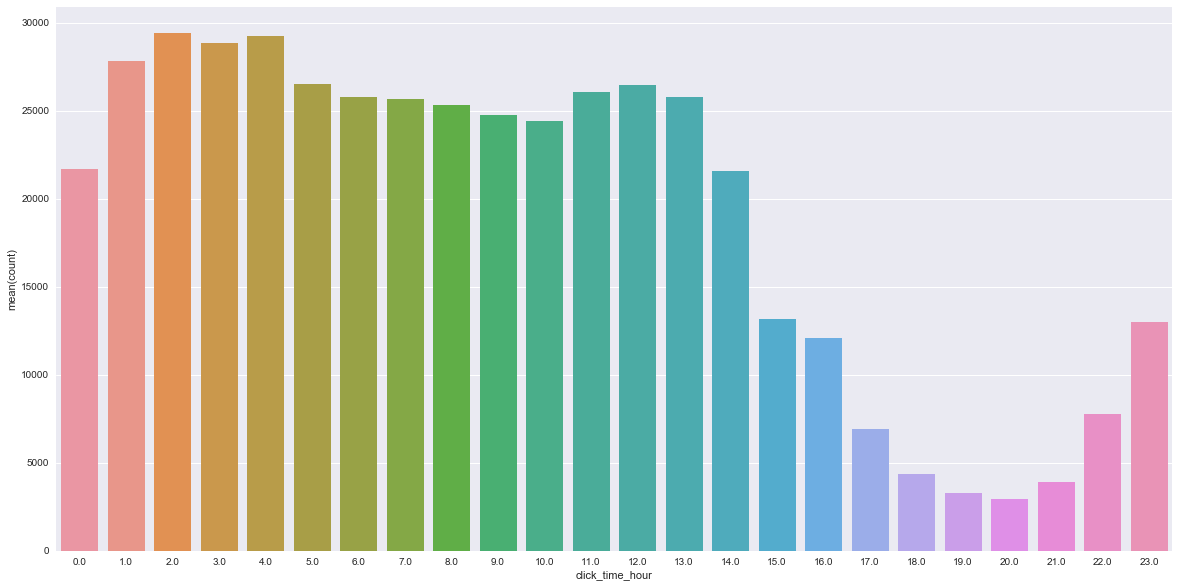

In [43]:
sns.plt.figure(figsize=(20, 10))
sns.barplot(x='click_time_hour', y='count', data=hour_count_ordered)
sns.plt.show()

#### Extracción de más variables

Sacar variable que indique número de clicks desde el primer click de un usuario concreto hasta ese click en ese momento. De la misma manera que el punto anterior, si convierte se resetea el contador y el primero pasa a ser el siguiente al convertido.

In [ ]:
w1 = W.partitionBy('ip', 'device', 'os').orderBy('click_time')

train_df = train_df.withColumn('prev_value', F.lag('is_attributed').over(w1))

# aux = aux.withColumn('times_attributed', F.sum('is_attributed').over(w1))

train_df = train_df.withColumn('times_attributed', F.when(F.isnull( F.sum('prev_value').over(w1) ), 0 ).otherwise( F.sum('prev_value').over(w1) )  )

w2 = W.partitionBy('ip', 'device', 'os', 'times_attributed').orderBy('click_time')

train_df = train_df.withColumn('n_previous_clicks', F.row_number().over(w2) - 1)

# train_df.persist(pyspark.StorageLevel.MEMORY_AND_DISK_SER)

# train_df.show(n = 10000, truncate = False)

Sacar variable que indique la diferencia en minutos desde el primer click de un usuario concreto (ip, device, os) hasta ese click en concreto. Si el usuario convierte, entonces se resetea el contador de diferencia y el primero será el siguiente registro al convertido (ordenados por tiempo).

In [ ]:
train_df = (train_df.withColumn('group_first', F.first('click_time').over(w2))
                    .withColumn('click_time_diff', F.abs( F.col('click_time').cast('long') - F.col('group_first').cast('long') ) / 60 )
           )

train_df = train_df.drop('group_first').drop('times_attributed').drop('prev_value')

# train_df.persist(pyspark.StorageLevel.MEMORY_AND_DISK_SER)

# train_df.show(n = 10000, truncate = False)

Sacar dos variables que cataloguen tanto a device como a os en distintas categorías en función de porcentaje de conversión que tienen (teniendo en cuenta el número de observaciones que constituyen, ver abajo).

In [18]:
aux = (train_df.select('device', 'is_attributed')
               .groupBy('device')
               .pivot('is_attributed')
               .count())

aux = (aux.withColumn('prcnt_0', F.when(~F.isnull('0') & ~F.isnull('1'), (aux['0'] / (aux['0'] + aux['1'])) * 100).otherwise(None))
          .withColumn('prcnt_1', F.when(~F.isnull('0') & ~F.isnull('1'), (aux['1'] / (aux['0'] + aux['1'])) * 100).otherwise(None))
          .na.fill(0)
          .select('device', 'prcnt_1', '1')
          .withColumn('prcnt_1', F.col('prcnt_1') / 100)
          .withColumn('custom_score', F.col('1') * F.col('prcnt_1'))
      )

# Quizás sería interesante usar broadcast join
train_df = aux.join(train_df, ['device'], 'inner')

# aux.persist(pyspark.StorageLevel.MEMORY_AND_DISK_SER)

# aux.show(truncate = False)

+------+--------------------+---+-------------------+
|device|prcnt_1             |1  |custom_score       |
+------+--------------------+---+-------------------+
|1580  |0.13043478260869565 |3  |0.3913043478260869 |
|496   |0.08888888888888889 |4  |0.35555555555555557|
|1238  |0.0                 |0  |0.0                |
|1829  |0.16666666666666663 |2  |0.33333333333333326|
|4101  |0.0                 |0  |0.0                |
|3749  |0.16666666666666663 |1  |0.16666666666666663|
|1591  |0.034722222222222224|5  |0.1736111111111111 |
|3997  |0.5                 |1  |0.5                |
|3175  |0.0                 |0  |0.0                |
|148   |0.169811320754717   |18 |3.056603773584906  |
|3918  |0.0                 |0  |0.0                |
|463   |0.13333333333333333 |2  |0.26666666666666666|
|1088  |0.32                |8  |2.56               |
|471   |0.06451612903225806 |2  |0.12903225806451613|
|833   |0.0                 |0  |0.0                |
|3794  |0.0                 

In [20]:
# aux.unpersist()

DataFrame[device: int, prcnt_1: double, 1: bigint, custom_score: double]

In [6]:
aux = (train_df.select('os', 'is_attributed')
               .groupBy('os')
               .pivot('is_attributed')
               .count())

aux = (aux.withColumn('prcnt_0', F.when(~F.isnull('0') & ~F.isnull('1'), (aux['0'] / (aux['0'] + aux['1'])) * 100).otherwise(None))
          .withColumn('prcnt_1', F.when(~F.isnull('0') & ~F.isnull('1'), (aux['1'] / (aux['0'] + aux['1'])) * 100).otherwise(None))
          .na.fill(0)
          .select('os', 'prcnt_1', '1')
          .withColumn('prcnt_1', F.col('prcnt_1') / 100)
          .withColumn('custom_score', F.col('1') * F.col('prcnt_1'))
      )

# Quizás sería interesante usar broadcast join
train_df = aux.join(train_df, ['os'], 'inner')

# aux.persist(pyspark.StorageLevel.MEMORY_AND_DISK_SER)

# aux.show(truncate = False)

+---+---------------------+---+------------------+
|os |prcnt_1              |1  |custom_score      |
+---+---------------------+---+------------------+
|833|0.0                  |0  |0.0               |
|463|0.0                  |0  |0.0               |
|496|0.0                  |0  |0.0               |
|471|0.0                  |0  |0.0               |
|148|0.0                  |0  |0.0               |
|392|0.0                  |0  |0.0               |
|858|0.0                  |0  |0.0               |
|897|0.0                  |0  |0.0               |
|623|0.0                  |0  |0.0               |
|737|0.0                  |0  |0.0               |
|243|0.0                  |0  |0.0               |
|31 |0.0012435508721801768|954|1.1863475320598886|
|808|0.0                  |0  |0.0               |
|137|0.0                  |0  |0.0               |
|451|0.0                  |0  |0.0               |
|251|0.0                  |0  |0.0               |
|85 |0.0                  |0  |

In [21]:
# aux.unpersist()

DataFrame[device: int, prcnt_1: double, 1: bigint, custom_score: double]

Lo mismo para app y channel

In [53]:
aux = (train_df.select('app', 'is_attributed')
               .groupBy('app')
               .pivot('is_attributed')
               .count())

aux = (aux.withColumn('prcnt_0', F.when(~F.isnull('0') & ~F.isnull('1'), (aux['0'] / (aux['0'] + aux['1'])) * 100).otherwise(None))
          .withColumn('prcnt_1', F.when(~F.isnull('0') & ~F.isnull('1'), (aux['1'] / (aux['0'] + aux['1'])) * 100).otherwise(None))
          .na.fill(0)
          .select('app', 'prcnt_1', '1')
          .withColumn('prcnt_1', F.col('prcnt_1') / 100)
          .withColumn('custom_score', F.col('1') * F.col('prcnt_1'))
      )

# Quizás sería interesante usar broadcast join
train_df = aux.join(train_df, ['app'], 'inner')

# aux.persist(pyspark.StorageLevel.MEMORY_AND_DISK_SER)

# aux.show(truncate = False)

+---+--------------------+---+-------------------+
|app|prcnt_1             |1  |custom_score       |
+---+--------------------+---+-------------------+
|463|0.0                 |0  |0.0                |
|148|0.1561518008218516  |646|100.87406333091613 |
|496|0.0                 |0  |0.0                |
|471|0.0                 |0  |0.0                |
|392|0.16666666666666663 |1  |0.16666666666666663|
|737|0.0                 |0  |0.0                |
|243|0.0                 |0  |0.0                |
|540|0.0                 |0  |0.0                |
|623|0.0                 |0  |0.0                |
|31 |0.006543723973825104|22 |0.1439619274241523 |
|580|0.0                 |0  |0.0                |
|251|0.03823529411764706 |13 |0.4970588235294118 |
|85 |0.0                 |0  |0.0                |
|137|0.0                 |0  |0.0                |
|65 |0.003867946934482408|114|0.4409459505309945 |
|458|0.0                 |0  |0.0                |
|481|0.09377559377559377 |229|2

In [49]:
# aux.unpersist()

DataFrame[app: int, prcnt_1: double, 1: bigint, custom_score: double]

In [55]:
aux = (train_df.select('channel', 'is_attributed')
               .groupBy('channel')
               .pivot('is_attributed')
               .count())

aux = (aux.withColumn('prcnt_0', F.when(~F.isnull('0') & ~F.isnull('1'), (aux['0'] / (aux['0'] + aux['1'])) * 100).otherwise(None))
          .withColumn('prcnt_1', F.when(~F.isnull('0') & ~F.isnull('1'), (aux['1'] / (aux['0'] + aux['1'])) * 100).otherwise(None))
          .na.fill(0)
          .select('channel', 'prcnt_1', '1')
          .withColumn('prcnt_1', F.col('prcnt_1') / 100)
          .withColumn('custom_score', F.col('1') * F.col('prcnt_1'))
      )

# Quizás sería interesante usar broadcast join
train_df = aux.join(train_df, ['channel'], 'inner')

# aux.persist(pyspark.StorageLevel.MEMORY_AND_DISK_SER)

# aux.show(truncate = False)

+-------+---------------------+-----+--------------------+
|channel|prcnt_1              |1    |custom_score        |
+-------+---------------------+-----+--------------------+
|496    |2.0092586639233588E-4|25   |0.005023146659808397|
|463    |2.4396038931835342E-4|230  |0.056110889543221285|
|471    |0.0                  |0    |0.0                 |
|243    |0.012761782632542547 |4956 |63.24739472688086   |
|251    |0.2857142857142857   |4    |1.1428571428571428  |
|451    |0.12703190848886214  |422  |53.60746538229982   |
|137    |3.036073241032074E-4 |699  |0.21222151954814197 |
|458    |0.0625               |1    |0.0625              |
|481    |6.549914121901325E-4 |503  |0.3294606803316366  |
|322    |5.957818644000477E-5 |3    |1.787345593200143E-4|
|108    |0.017480166733898076 |130  |2.27242167540675    |
|211    |3.3847754733366727E-4|350  |0.11846714156678355 |
|101    |0.015451006765171338 |33176|512.6026004413243   |
|126    |0.0013759119416357354|43   |0.05916421349033662

In [57]:
# aux.unpersist()

DataFrame[channel: int, prcnt_1: double, 1: bigint, custom_score: double]

Parar SparkContext

In [14]:
sc.stop()